## Task 1 (2 points + 1 bonus point + 1 super-bonus point)

(Titanic data again)

Build a model with `sklearn`'s `LogisticRegression` to get the accuracy of at least 0.80 (0.82 for the bonus point, 0.85 for the super-bonus point) on the test set.

Some (optional) suggestions:
- Add new features (e.g. missing value indicator columns)
- Fill missing values
- Encode categorical features (e.g. one-hot encoding)
- Scale the features (e.g. with standard or robust scaler)
- Think of other ways of preprocessing the features (e.g. `Fare` $\to$ `log(Fare)`)
- Try adding polynomial features



In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
data = pd.read_csv("train.csv", index_col='PassengerId')
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### About the data
Here's some of the columns
* Name - a string with person's full name
* Survived - 1 if a person survived the shipwreck, 0 otherwise.
* Pclass - passenger class. Pclass == 3 is cheap'n'cheerful, Pclass == 1 is for moneybags.
* Sex - a person's gender
* Age - age in years, if available
* SibSp - number of siblings on a ship
* Parch - number of parents on a ship
* Fare - ticket cost
* Embarked - port where the passenger embarked
 * C = Cherbourg; Q = Queenstown; S = Southampton

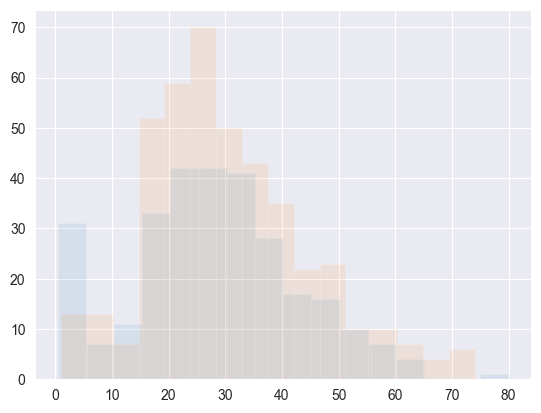

In [86]:
plt.hist(data[data.Survived == 1].Age, bins='auto', alpha=0.1)
plt.hist(data[data.Survived == 0].Age, bins='auto', alpha=0.1)
plt.show()

In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

def feature_selection_and_preprocessing(dataset):
  # <YOUR CODE>
  # E.g.:
    features = dataset[["SibSp", "Parch", "Fare", 'Pclass']].copy()
    features["Age"] = dataset.Age.fillna(dataset.Age.median())

    features['Embarked'] = data.Embarked.fillna('unknown')
    features['Missing'] = dataset.isna().sum(axis=1)
    features['IsMale'] = np.where(dataset.Sex=='male', 1, 0)
    # features['IsKid'] = np.where(dataset.Age <= 16, 1, 0)
    return features

model = make_pipeline(
    # <YOUR CODE>
    # E.g.
    make_column_transformer(
        (OneHotEncoder(sparse_output=False), ['Embarked']),
        # (PolynomialFeatures(3), ['Age']),
        # (PolynomialFeatures(3), ['Missing']),
        # (PolynomialFeatures(3), ['Fare']),
        remainder='passthrough'
    ),
    StandardScaler(),
    LogisticRegression(max_iter=500)
)

# rfe = RFE(model, 8)

# Validation code (do not touch)
data = pd.read_csv("train.csv", index_col='PassengerId')
data_train, data_test = train_test_split(data, test_size=200, random_state=42)

    # rfe.fit(    feature_selection_and_preprocessing(
    #         data_train.drop('Survived', axis=1)
    #     ),
    #     data_train['Survived'])

model.fit(
    feature_selection_and_preprocessing(
        data_train.drop('Survived', axis=1)
    ),
    data_train['Survived']
)

train_predictions = model.predict(
    feature_selection_and_preprocessing(
        data_train.drop('Survived', axis=1)
    )
)

test_predictions = model.predict(
    feature_selection_and_preprocessing(
        data_test.drop('Survived', axis=1)
    )
)

print("Train accuracy:", accuracy_score(
    data_train['Survived'],
    train_predictions
))
print("Test accuracy:", accuracy_score(
    data_test['Survived'],
    test_predictions
))

Train accuracy: 0.7973950795947902
Test accuracy: 0.825


In [74]:
model = make_pipeline(
    # <YOUR CODE>
    # E.g.
    make_column_transformer(
        (OneHotEncoder(sparse_output=False), ['Embarked']),
        (OneHotEncoder(sparse_output=False), ['Sex']),
        # (PolynomialFeatures(3), ['Age']),
        remainder='passthrough'
    ),
    RobustScaler()
    )
model.fit(
    feature_selection_and_preprocessing(
        data_train.drop('Survived', axis=1)
    ),
    data_train['Survived']
)
model.transform( feature_selection_and_preprocessing(
        data_train.drop('Survived', axis=1)
    ))

array([[ 0.        ,  0.        ,  0.        , ...,  2.53846154,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.15384615,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -1.61538462,
        -1.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -1.07692308,
        -2.        , -1.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.53846154,
        -2.        , -1.        ]])